# Upsampling-based subpixel refinement

This notebook demonstrates the use of DFT-upsampling-based subpixel refinement when running `blobfinder`, which gives more precise results than the standard approach at the expense of computation time.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import libertem.api as lt
from scipy.ndimage import fourier_shift

In [3]:
from libertem_blobfinder.base.utils import cbed_frame
from libertem_blobfinder.common.patterns import Circular
from libertem_blobfinder.udf.correlation import run_blobfinder

## Dataset

We generate a small, demo dataset containing a single circular disk which is shifted by a small amount across ecah frame in the scan grid:

In [4]:
nav_shape = (12, 45)
sig_shape = (64, 64)
radius = 6
ny, nx = nav_shape
yshift = (-1, 1)  # px
xshift = (-3, 3)  # px


The image shifting is performed using the Fourier method to give a result independent of the pixel grid:

In [5]:
frame, _, _ = cbed_frame(*sig_shape, radius=radius, a=(100, 100), b=(100, 100))
frame = frame[0]
frame_fft = np.fft.fft2(frame.astype(np.float32))
frames = np.zeros(nav_shape + sig_shape, dtype=np.float32)
true_shifts = np.zeros(nav_shape + (2,))
for yi, yd in enumerate(np.linspace(*yshift, num=ny, endpoint=True)):
    for xi, xd in enumerate(np.linspace(*xshift, num=nx, endpoint=True)):
        true_shifts[yi, xi] = (yd * (-1 * xi / nx), xd * (yi / ny))
        frames[yi, xi, ...] = np.fft.ifft2(
            fourier_shift(frame_fft, true_shifts[yi, xi])
        ).real.astype(np.float32)

The maximum shift in the dataset is on the order of `3 px`.

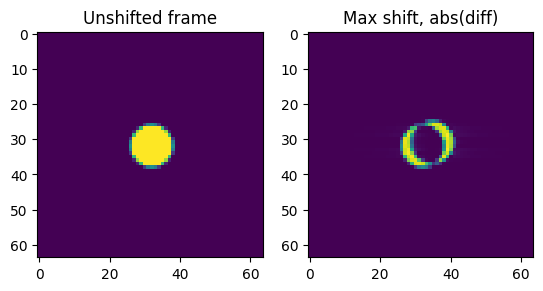

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(frame)
ax1.set_title('Unshifted frame')
ax2.imshow(np.abs(frame - frames[-1, -1]))
ax2.set_title('Max shift, abs(diff)');

## Run `blobfinder`

The dataset is small so we will use an inline `Context` and a dataset in memory.

In [7]:
ctx = lt.Context.make_with('inline')
ds = ctx.load('memory', data=frames)

### Without upsampling

By default `blobfinder` calculates subpixel peak positions using a local centre-of-mass around the maxima of the correlation map.

In [8]:
sum_result, centers, refineds, peak_values, peak_elevations, peaks = run_blobfinder(
    ctx,
    ds,
    match_pattern=Circular(radius),
    num_peaks=1,
    upsample=False,
)

This approach leads to aliasing on the order of `+/- 0.3 px`. This becomes visible when the maximium shifts in a dataset are small. The aliasing is visible as banding in the color plot for each dimension:

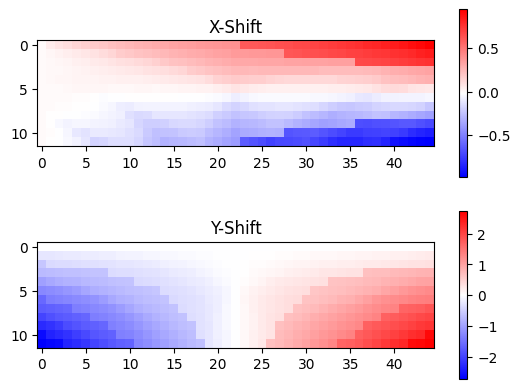

In [9]:
fig, (ax1, ax2) = plt.subplots(2, 1)
shifts = (refineds.data - np.asarray(sig_shape) // 2)[..., 0, :]
im = ax1.imshow(shifts[..., 0], cmap='bwr')
ax1.set_title('X-Shift')
plt.colorbar(im, ax=ax1)
im = ax2.imshow(shifts[..., 1], cmap='bwr')
ax2.set_title('Y-Shift')
plt.colorbar(im, ax=ax2);

### With upsampling

Using the `upsample=True` option on any of the `blobfinder` API endpoints enables sub-pixel precision calculated using upsampling of the DFT of the correlation map, rather than centre-of-mass. This increases the computation time but can be worth it to remove aliasing.

By default an upsampling of `20x` is used but the argument also accepts an integer to specify more or less precision.

In [10]:
sum_result, centers, refineds, peak_values, peak_elevations, peaks = run_blobfinder(
    ctx,
    ds,
    match_pattern=Circular(radius),
    num_peaks=1,
    upsample=True,
)

It is clear from the lack of color banding that the aliasing is reduced in this case.

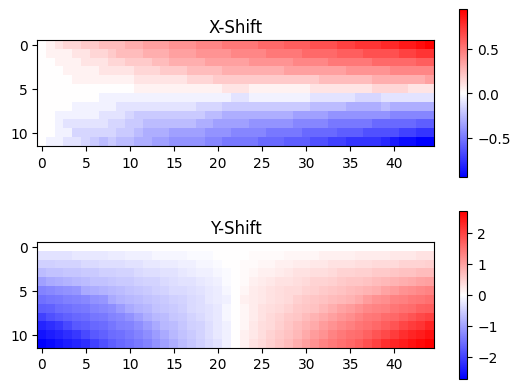

In [11]:
fig, (ax1, ax2) = plt.subplots(2, 1)
shifts_us = (refineds.data - np.asarray(sig_shape) // 2)[..., 0, :]
im = ax1.imshow(shifts_us[..., 0], cmap='bwr')
ax1.set_title('X-Shift')
plt.colorbar(im, ax=ax1)
im = ax2.imshow(shifts_us[..., 1], cmap='bwr')
ax2.set_title('Y-Shift')
plt.colorbar(im, ax=ax2);

### Comparison

As we have only a single disk in the frame we can measure the shift using CoM directly:

In [12]:
cy, cx = np.asarray(sig_shape) // 2
com_a = ctx.create_com_analysis(ds, cx=cx, cy=cy)
com_r = ctx.run(com_a)
y_shift_com = com_r.y.raw_data

We see that the frame CoM result precisely matches the shifts used when generating the dataset.

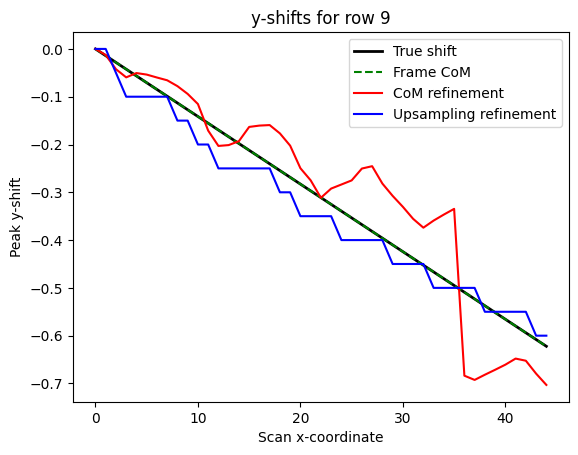

In [13]:
fig, ax = plt.subplots()
sl = np.s_[9, :, 0]
xvals = np.arange(true_shifts[sl].size)
ax.plot(xvals, true_shifts[sl], 'k', label="True shift", linewidth=2)
ax.plot(xvals, y_shift_com[sl[:2]], 'g--', label="Frame CoM")
ax.plot(xvals, shifts[sl], 'r', label="CoM refinement")
ax.plot(xvals, shifts_us[sl], 'b', label="Upsampling refinement")
ax.set_xlabel('Scan x-coordinate')
ax.set_ylabel('Peak y-shift')
ax.set_title(f'y-shifts for row {sl[0]}')
ax.legend();

In addition, we see the strong aliasing in the standard CoM-based refinement, and the reduced aliasing when using upsampling. The steps in the upsampling curve are due to the default upsampling factor of `20x`, which means the precision of the subpixel centre is at most `1 /  20 == 0.05 px`. This can be improved by passing the desired upsampling factor to the `blobfinder` api.

### With `upsample == 50`

In [14]:
upsample_f = 50
sum_result, centers, refineds, peak_values, peak_elevations, peaks = run_blobfinder(
    ctx,
    ds,
    match_pattern=Circular(radius),
    num_peaks=1,
    upsample=upsample_f,
)
shifts_us50 = (refineds.data - np.asarray(sig_shape) // 2)[..., 0, :]

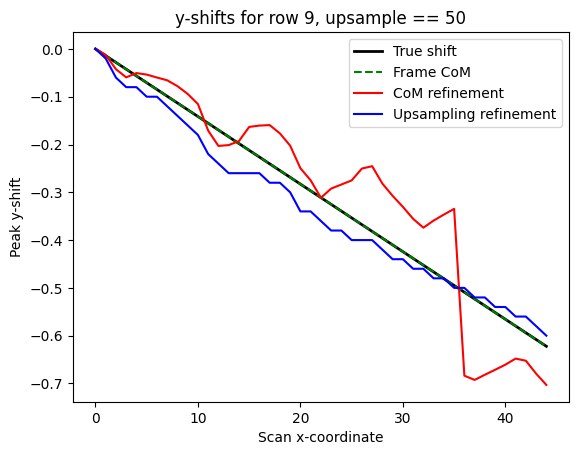

In [15]:
fig, ax = plt.subplots()
xvals = np.arange(true_shifts[sl].size)
ax.plot(xvals, true_shifts[sl], 'k', label="True shift", linewidth=2)
ax.plot(xvals, y_shift_com[sl[:2]], 'g--', label="Frame CoM")
ax.plot(xvals, shifts[sl], 'r', label="CoM refinement")
ax.plot(xvals, shifts_us50[sl], 'b', label="Upsampling refinement")
ax.set_xlabel('Scan x-coordinate')
ax.set_ylabel('Peak y-shift')
ax.set_title(f'y-shifts for row {sl[0]}, upsample == {upsample_f}')
ax.legend();